now only fish/engine

Trial 20 Complete [00h 01m 02s]
val_accuracy: 0.7795959711074829

Best val_accuracy So Far: 0.7987878620624542
Total elapsed time: 00h 20m 22s
Epoch 1/200
220/220 [==============================] - 2s 7ms/step - loss: 0.6026 - accuracy: 0.6998 - val_loss: 0.5184 - val_accuracy: 0.7402
Epoch 2/200
220/220 [==============================] - 1s 6ms/step - loss: 0.5649 - accuracy: 0.7281 - val_loss: 0.5047 - val_accuracy: 0.7398
Epoch 3/200
220/220 [==============================] - 1s 6ms/step - loss: 0.5333 - accuracy: 0.7388 - val_loss: 0.4971 - val_accuracy: 0.7535
Epoch 4/200
220/220 [==============================] - 1s 5ms/step - loss: 0.5104 - accuracy: 0.7531 - val_loss: 0.4930 - val_accuracy: 0.7596
Epoch 5/200
220/220 [==============================] - 1s 5ms/step - loss: 0.4954 - accuracy: 0.7691 - val_loss: 0.4992 - val_accuracy: 0.7503
Epoch 6/200
220/220 [==============================] - 1s 5ms/step - loss: 0.4968 - accuracy: 0.7666 - val_loss: 0.4971 - val_accuracy: 0.7552

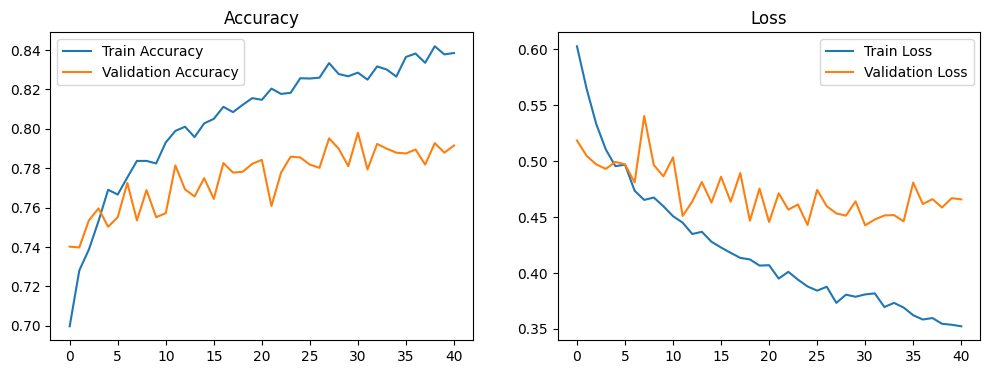

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
import matplotlib.pyplot as plt

# Paths
data_folder = "./time_sets_standardized"

# Function to load and process individual vessel data (updated)
def load_and_process_vessel_data(folder_path):
    data, labels = [], []
    status_counts = {}

    for file in os.listdir(folder_path):
        if file.endswith(".csv"):
            df = pd.read_csv(os.path.join(folder_path, file))

            if "Heading" not in df.columns or df["Heading"].isnull().any():
                continue  # Skip files with missing or invalid data

            # Extract the time series features
            sog = df["SOG"].values
            cog = df["COG"].values
            heading = df["Heading"].values

            # Extract label
            label = df["Navigational status"].iloc[0]
            if label in ["Under way using engine", "Engaged in fishing"]:
                # Calculate statistical features for SOG, COG, and Heading
                sog_mean = np.mean(sog)
                sog_min = np.min(sog)
                sog_max = np.max(sog)
                sog_std = np.std(sog)
                sog_slope = np.polyfit(range(len(sog)), sog, 1)[0]  # Linear fit slope

                cog_mean = np.mean(cog)
                cog_min = np.min(cog)
                cog_max = np.max(cog)
                cog_std = np.std(cog)
                cog_slope = np.polyfit(range(len(cog)), cog, 1)[0]  # Linear fit slope

                heading_mean = np.mean(heading)
                heading_min = np.min(heading)
                heading_max = np.max(heading)
                heading_std = np.std(heading)

                # Flatten the time series for SOG, COG, and Heading
                sog_flat = sog
                cog_flat = cog
                heading_flat = heading

                # Combine the statistical features and flattened time series into a single row
                features = [
                    sog_mean, sog_min, sog_max, sog_std, sog_slope,
                    cog_mean, cog_min, cog_max, cog_std, cog_slope,
                    heading_mean, heading_min, heading_max, heading_std
                ]

                # Flatten the time series and add it to the feature list
                features.extend(sog_flat)
                features.extend(cog_flat)
                features.extend(heading_flat)

                data.append(features)
                labels.append(label)

                if label not in status_counts:
                    status_counts[label] = 0
                status_counts[label] += 1

    # Convert to numpy arrays
    return np.array(data), np.array(labels), status_counts

# Load and preprocess data
data, labels, status_counts = load_and_process_vessel_data(data_folder)

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Print class distribution
print("Class distribution:", dict(zip(label_encoder.classes_, np.bincount(labels))))

# Debugging: Show one sample row from the final dataset
print("Sample row from the final dataset:")
print(data[0])  # Shows the first sample row

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Apply undersampling to balance the classes
def undersample_data(X, y):
    class_0 = X[y == 0]
    class_1 = X[y == 1]

    class_1_undersampled = resample(class_1, replace=False, n_samples=len(class_0), random_state=42)

    X_balanced = np.vstack((class_0, class_1_undersampled))
    y_balanced = np.hstack((np.zeros(len(class_0)), np.ones(len(class_1_undersampled))))

    return X_balanced, y_balanced

X_train_balanced, y_train_balanced = undersample_data(X_train, y_train)

# Standardize features
scaler = StandardScaler()
X_train_balanced = scaler.fit_transform(X_train_balanced)
X_test = scaler.transform(X_test)

# Define the model builder function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_1', min_value=64, max_value=512, step=64),
                    activation=hp.Choice('activation_1', values=['relu', 'tanh']),
                    input_dim=X_train_balanced.shape[1]))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))

    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(units=hp.Int(f'units_{i+2}', min_value=64, max_value=512, step=64),
                        activation=hp.Choice(f'activation_{i+2}', values=['relu', 'tanh'])))
        model.add(Dropout(rate=hp.Float(f'dropout_{i+2}', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(Dense(2, activation='softmax'))
    optimizer = tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'))
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Set up the tuner
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    directory='kt_hyperparam_search',
    project_name='vessel_navigation_bayesian'
)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Run the tuner
tuner.search(X_train_balanced, y_train_balanced, epochs=100, validation_data=(X_test, y_test),
             batch_size=32, callbacks=[early_stopping])

# Get the best hyperparameters and build the model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(X_train_balanced, y_train_balanced, epochs=200, validation_data=(X_test, y_test),
                         batch_size=32, callbacks=[early_stopping])

# Evaluate the best model
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()

plot_history(history)


In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import keras_tuner as kt

# Paths
data_folder = "./time_sets_standardized"

# Function to load and process individual vessel data
def load_and_process_vessel_data(folder_path):
    data, labels = [], []
    status_counts = {}

    for file in os.listdir(folder_path):
        if file.endswith(".csv"):
            df = pd.read_csv(os.path.join(folder_path, file))

            if "Heading" not in df.columns or df["Heading"].isnull().any():
                continue  # Skip files with missing or invalid data
            
            # Extract the time series features
            sog = df["SOG"].values
            cog = df["COG"].values
            heading = df["Heading"].values

            # Extract label
            label = df["Navigational status"].iloc[0]
            if label in ["Under way using engine", "Engaged in fishing"]:
                # Calculate statistics for each feature
                sog_mean = np.mean(sog)
                sog_min = np.min(sog)
                sog_max = np.max(sog)
                sog_std = np.std(sog)
                
                cog_mean = np.mean(cog)
                cog_min = np.min(cog)
                cog_max = np.max(cog)
                cog_std = np.std(cog)
                
                heading_mean = np.mean(heading)
                heading_min = np.min(heading)
                heading_max = np.max(heading)
                heading_std = np.std(heading)
                
                # Rate of change (slope) for SOG and COG
                sog_slope = np.polyfit(range(len(sog)), sog, 1)[0]  # Linear fit slope
                cog_slope = np.polyfit(range(len(cog)), cog, 1)[0]  # Linear fit slope

                # Add to the dataset
                features = [
                    sog_mean, sog_min, sog_max, sog_std, sog_slope,
                    cog_mean, cog_min, cog_max, cog_std, cog_slope,
                    heading_mean, heading_min, heading_max, heading_std
                ]
                
                data.append(features)
                labels.append(label)
                
                if label not in status_counts:
                    status_counts[label] = 0
                status_counts[label] += 1

    return np.array(data), np.array(labels), status_counts

# Load and preprocess data
data, labels, status_counts = load_and_process_vessel_data(data_folder)

# Encode labels (e.g., "Under way using engine" -> 0, "Engaged in fishing" -> 1)
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Apply undersampling to balance the classes
def undersample_data(X, y):
    class_0 = X[y == 0]  # Minority class (0)
    class_1 = X[y == 1]  # Majority class (1)
    
    class_1_undersampled = resample(class_1, replace=False, n_samples=len(class_0), random_state=42)
    
    X_balanced = np.vstack((class_0, class_1_undersampled))
    y_balanced = np.hstack((np.zeros(len(class_0)), np.ones(len(class_1_undersampled))))
    
    return X_balanced, y_balanced

X_train_balanced, y_train_balanced = undersample_data(X_train, y_train)

# Function to build the model for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_layer_1', min_value=64, max_value=256, step=32),
        activation='relu',
        input_dim=X_train_balanced.shape[1]
    ))
    model.add(Dropout(rate=hp.Float('dropout_layer_1', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(
        units=hp.Int('units_layer_2', min_value=32, max_value=128, step=16),
        activation='relu'
    ))
    model.add(Dropout(rate=hp.Float('dropout_layer_2', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(2, activation='softmax'))  # Binary classification output
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Reload the tuner
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    directory='kt_hyperparam_search',
    project_name='vessel_navigation_bayesian'
)

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:", best_hps.values)

# Build and train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train_balanced, y_train_balanced,
    epochs=200,  # Adjust as needed
    batch_size=64,
    validation_data=(X_test, y_test)
)

# Evaluate the model
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")


Reloading Tuner from kt_hyperparam_search\vessel_navigation_bayesian\tuner0.json
Best Hyperparameters: {'units_1': 320, 'activation_1': 'tanh', 'dropout_1': 0.1, 'num_layers': 3, 'units_2': 512, 'activation_2': 'tanh', 'dropout_2': 0.1, 'learning_rate': 0.0003173709295050098, 'units_3': 192, 'activation_3': 'tanh', 'dropout_3': 0.30000000000000004, 'units_4': 320, 'activation_4': 'tanh', 'dropout_4': 0.2}
Epoch 1/200
110/110 [==============================] - 1s 9ms/step - loss: 7.1670 - accuracy: 0.5350 - val_loss: 0.7657 - val_accuracy: 0.5899
Epoch 2/200
110/110 [==============================] - 1s 6ms/step - loss: 1.2495 - accuracy: 0.5373 - val_loss: 0.7306 - val_accuracy: 0.4287
Epoch 3/200
110/110 [==============================] - 0s 4ms/step - loss: 0.8344 - accuracy: 0.5465 - val_loss: 0.6945 - val_accuracy: 0.4683
Epoch 4/200
110/110 [==============================] - 0s 4ms/step - loss: 0.7346 - accuracy: 0.5621 - val_loss: 0.6775 - val_accuracy: 0.5099
Epoch 5/200
110/110

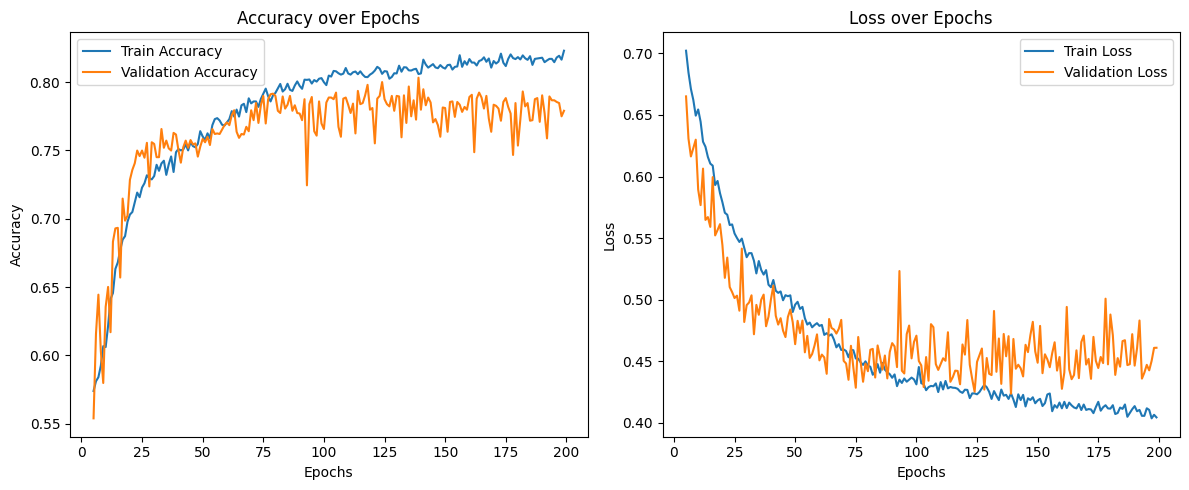

In [3]:
import matplotlib.pyplot as plt

def plot_learning_curve(history, epochs_to_skip=5):
    plt.figure(figsize=(12, 5))

    # Slice history to skip the first 'epochs_to_skip' epochs
    history_epochs = range(epochs_to_skip, len(history.history['accuracy']))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_epochs, history.history['accuracy'][epochs_to_skip:], label='Train Accuracy')
    plt.plot(history_epochs, history.history['val_accuracy'][epochs_to_skip:], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history_epochs, history.history['loss'][epochs_to_skip:], label='Train Loss')
    plt.plot(history_epochs, history.history['val_loss'][epochs_to_skip:], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_learning_curve(history)



78/78 [==============================] - 0s 1ms/step


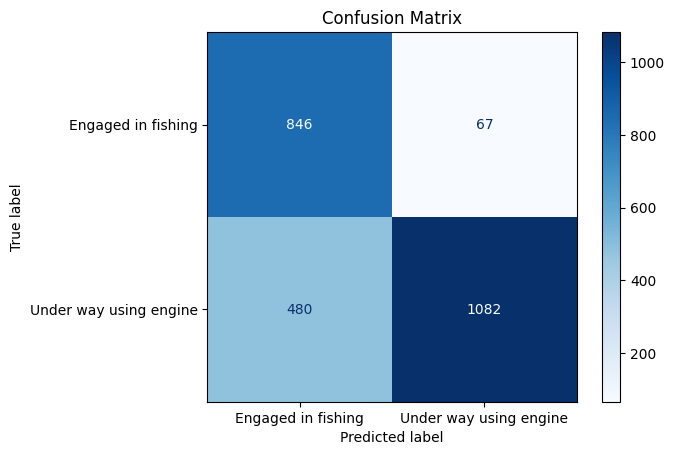

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions on the test data
y_pred = best_model.predict(X_test)
y_pred_class = np.argmax(y_pred, axis=1)  # Convert to class labels (0 or 1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_class)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [5]:
from sklearn.metrics import classification_report

# Print precision, recall, and F1-score
report = classification_report(y_test, y_pred_class, target_names=label_encoder.classes_)
print("Classification Report:")
print(report)


Classification Report:
                        precision    recall  f1-score   support

    Engaged in fishing       0.64      0.93      0.76       913
Under way using engine       0.94      0.69      0.80      1562

              accuracy                           0.78      2475
             macro avg       0.79      0.81      0.78      2475
          weighted avg       0.83      0.78      0.78      2475



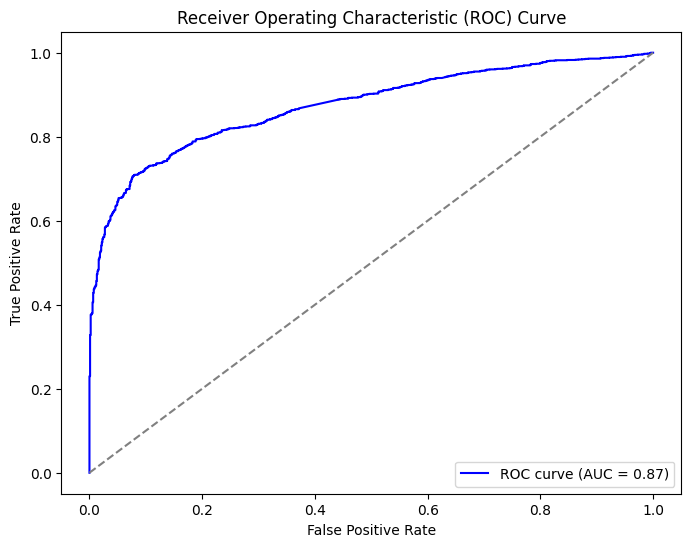

In [6]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC for each class
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, 1])  # Using class 1 for positive class
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal (random classifier)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
